# Recommender System - Matrix Factorization with Keras

Yang Xi, 2021-09-17<br>

References:
- AlgoExpert, Recommender Systems
- https://keras.io/examples/structured_data/collaborative_filtering_movielens/
- https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929
- https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
- https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
- https://queirozf.com/entries/evaluation-metrics-for-ranking-problems-introduction-and-examples
- https://en.wikipedia.org/wiki/Discounted_cumulative_gain

<br>

This notebook presents how to train and validate a recommender system based matrix factorization, using Keras API
* Prepossing of data
* Model construction and training
* Evaluate ranking performance (NDCG) on train and validation data sets
* Make recommandation

In [1]:
import numpy as np
np.random.seed(0)

## Load Data

In [2]:
import pandas as pd

dfRating = pd.read_csv('data/ratings.csv')
print(f"Ratings data contains {dfRating.shape[0]} rows from {dfRating['userId'].nunique()} users, {dfRating['movieId'].nunique()} movies, with ratings range {dfRating['rating'].min()} to {dfRating['rating'].max()}")
dfRating.head(3)

Ratings data contains 100836 rows from 610 users, 9724 movies, with ratings range 0.5 to 5.0


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


## Preprocessing

Encode users and movies as sequencial intergers index -- this is required by keras Embedding.

Preferably, encoding should be done after train/test split to avoid potentail data leaking.


In [3]:
from sklearn.preprocessing import LabelEncoder

encUser = LabelEncoder()
dfRating['userIndex'] = encUser.fit_transform(dfRating['userId'])

encMovie = LabelEncoder()
dfRating['movieIndex'] = encMovie.fit_transform(dfRating['movieId'])

dfRating.head(3)

,userId,movieId,rating,timestamp,userIndex,movieIndex
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,2
2,1,6,4.0,964982224,0,5


## Split Train and Test Sets

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Keep these dataframes for validation
colsSelect = ['userIndex', 'movieIndex', 'rating']
dfTrain = dfRating[colsSelect].sample(frac=0.8, random_state=21)
dfVali = dfRating.drop(dfTrain.index)

# For model
XTrain, yTrain = dfTrain[['userIndex', 'movieIndex']].values, dfTrain['rating'].values
XVali, yVali = dfVali[['userIndex', 'movieIndex']].values, dfVali['rating'].values

print(f"Train set size: X = {XTrain.shape}, y = {yTrain.shape}")
print(f"Validation set size: X = {XVali.shape}, y = {yVali.shape}")

# More standardization to fit in sigmoid activation function
scaler = MinMaxScaler()
yTrain = scaler.fit_transform(yTrain.reshape(-1, 1))[:,0]
yVali = scaler.transform(yVali.reshape(-1, 1))[:,0]

Train set size: X = (80669, 2), y = (80669,)
Validation set size: X = (20167, 2), y = (20167,)


## Train Model

In [5]:
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.layers import Dot, Add, Activation
from keras.optimizers import Adam

class Recommender(Model):
    def __init__(self, nUsers, nMovies, nFactors):
        super(Recommender, self).__init__()
        self.embeddingUser = Embedding(
            nUsers,
            nFactors,
            embeddings_initializer='he_normal',
            embeddings_regularizer=l2(1e-6)
        )
        self.biasUser = Embedding(nUsers, 1)
        
        self.embeddingMovie = Embedding(
            nMovies,
            nFactors,
            embeddings_initializer='he_normal',
            embeddings_regularizer=l2(1e-6)
        )
        self.biasMovie = Embedding(nMovies, 1)
        
    def call(self, arInput):
        vecUser = self.embeddingUser(arInput[:,0])
        biasUser = self.biasUser(arInput[:,0])
        vecMovie = self.embeddingMovie(arInput[:,1])
        biasMovie = self.biasMovie(arInput[:,1])
        
        x = Dot(axes=1)([vecUser, vecMovie])
        x = Add()([x, biasUser, biasMovie])
        x = Activation('sigmoid')(x)
        return x


In [6]:
EMBEDDING_SIZE = 50

nUsers = dfRating['userIndex'].nunique()
nMovies = dfRating['movieIndex'].nunique()

model = Recommender(nUsers, nMovies, EMBEDDING_SIZE)
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0005))

fitHistory = model.fit(
    x=XTrain,
    y=yTrain,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(XVali, yVali),
)

Epoch 1/5
1261/1261 [==============================] - 6s 4ms/step - loss: 0.0717 - val_loss: 0.0606
Epoch 2/5
1261/1261 [==============================] - 6s 4ms/step - loss: 0.0489 - val_loss: 0.0432
Epoch 3/5
1261/1261 [==============================] - 5s 4ms/step - loss: 0.0372 - val_loss: 0.0400
Epoch 4/5
1261/1261 [==============================] - 6s 4ms/step - loss: 0.0325 - val_loss: 0.0390
Epoch 5/5
1261/1261 [==============================] - 6s 4ms/step - loss: 0.0291 - val_loss: 0.0386


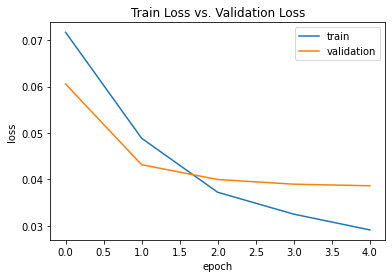

In [7]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(fitHistory.history['loss'])
plt.plot(fitHistory.history['val_loss'])
plt.title('Train Loss vs. Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate Model Performance

Let's evaluate the performance using **Normalized Discounted Cumulative Gain (NDCG)**

Note on `ndcg_score` from `sklearn`:
* The formulation implemented is the non-traditional one, with (2^rel - 1) in the numerator
* The implementation works normally if length of input list is smaller than k
* If a list of lists is inputed, it will calculate NDCG for each list, then return the mean
    * The implementation will fail if the lists are of different length
* The implementation also will fail if the list(s) contain only single element


In [8]:
from sklearn.metrics import ndcg_score

# Evaluate performnace based on top N movies
TOP_N_MOVIE = 3

def CalcNDCG(df, colActual='rating', colPred='predScore', k=TOP_N_MOVIE):
    ar = df[[colActual, colPred]].values.T
    return ndcg_score([ar[0]], [ar[1]], k=k, ignore_ties=False)


### Train Performance

In [9]:
dfTrain['predScore'] = model.predict(XTrain).flatten()

## Filter for user with at least N movies
seUserMoviesCount = dfTrain.groupby('userIndex').size()
indexSelect = dfTrain['userIndex'].isin(seUserMoviesCount[seUserMoviesCount>=TOP_N_MOVIE].index)
print(f"{indexSelect.sum()} rows from {len(dfTrain)} rows are by users watched at least minimum {TOP_N_MOVIE} movies.")

ndcgTrain = dfTrain[indexSelect].groupby(['userIndex']).apply(CalcNDCG).mean()
print(f"Average NDCG of train set = {ndcgTrain:.2f}")

80669 rows from 80669 rows are by users watched at least minimum 3 movies.
Average NDCG of train set = 0.91


### Validation Performance

In [10]:
dfVali['predScore'] = model.predict(XVali).flatten()

## Filter for user with at least N movies
seUserMoviesCount = dfVali.groupby('userIndex').size()
indexSelect = dfVali['userIndex'].isin(seUserMoviesCount[seUserMoviesCount>=TOP_N_MOVIE].index)
print(f"{indexSelect.sum()} rows from {len(dfVali)} rows are by users watched at least minimum {TOP_N_MOVIE} movies.")

ndcgVali = dfVali[indexSelect].groupby(['userIndex']).apply(CalcNDCG).mean()
print(f"Average NDCG of validation set = {ndcgVali:.2f}")

20143 rows from 20167 rows are by users watched at least minimum 3 movies.
Average NDCG of validation set = 0.89


## Make Recommendation

In [11]:
# Load movies data
dfMovie = pd.read_csv('data/movies.csv')
dfMovie.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


### Top 5 movies to be recommended to a given user

In [16]:
def MakeRecommandation(userId, topN=5, includeWatched=True):
    # Prepare input array
    if not includeWatched:
        sMovieIdWatched = set(dfRating[dfRating['userId'] == userId]['movieId'])
        sMovieIdNotWatched = set(dfMovie[~dfMovie['movieId'].isin(sMovieIdWatched)]['movieId'])
        print(f"User {userId} has watched {len(sMovieIdWatched)} movies, and there are {len(sMovieIdNotWatched)} movies not watched yet.")

        arMoiveIndex = encMovie.transform(list(sMovieIdNotWatched.intersection(encMovie.classes_)))
        print(f"There are {len(arMoiveIndex)} movies not wated with encoding.")
    
    else:
        arMoiveIndex = encMovie.transform(encMovie.classes_)

    arUserIndex = encUser.transform([userId])
    arUserMovieIndex = np.hstack((
        [arUserIndex]*len(arMoiveIndex),
        arMoiveIndex.reshape(-1,1)
    ))
    print(f"Shape of input array = {arUserMovieIndex.shape}") # [[473, 5847], [473, 2], [473, 3], ...]

    # Predict
    arPred = model.predict(arUserMovieIndex).flatten()
    print(f"Predicted rating for {len(arPred)} movies.")

    # Filter top N
    arTopMoviePredIndex = arPred.argsort()[-topN:][::-1] # [::-1] is to reverse the array
    arTopMoviePredRating = scaler.inverse_transform([arPred[arTopMoviePredIndex]]).flatten()

    arTopMovieIndex = arMoiveIndex[arTopMoviePredIndex]
    print(f"Enconded index of top rated movies = {arTopMovieIndex}")
    arTopMovieId = encMovie.inverse_transform(arTopMovieIndex)
    print(f"Movie ID of top rated movies = {arTopMovieId}")

    dfRecommend = pd.DataFrame({'movieId':arTopMovieId, 'predictedRating':arTopMoviePredRating})
    return dfRecommend.merge(dfMovie, 'left', 'movieId')


In [17]:
userId = 474

MakeRecommandation(474, includeWatched=False)

User 474 has watched 2108 movies, and there are 7634 movies not watched yet.
There are 7616 movies not wated with encoding.
Shape of input array = (7616, 2)
Predicted rating for 7616 movies.
Enconded index of top rated movies = [ 959 4390  661 6755 9053]
Movie ID of top rated movies = [  1261   6460    866  60069 142488]


,movieId,predictedRating,title,genres
0,1261,4.296661,Evil Dead II (Dead by Dawn) (1987),Action|Comedy|Fantasy|Horror
1,6460,4.286385,"Trial, The (Procès, Le) (1962)",Drama
2,866,4.277146,Bound (1996),Crime|Drama|Romance|Thriller
3,60069,4.276143,WALL·E (2008),Adventure|Animation|Children|Romance|Sci-Fi
4,142488,4.269154,Spotlight (2015),Thriller


In [18]:
# As benchmark: genres of movies this user has rated

dfMovieWatched = dfRating[dfRating['userId'] == userId][['userId', 'movieId', 'rating']]
dfMovieWatched = dfMovieWatched.merge(dfMovie, 'left', 'movieId')
dfGenresCount = dfMovieWatched.groupby(['genres']).size().rename('count').reset_index()
dfGenresRating = dfMovieWatched.groupby(['genres'])['rating'].mean().rename('avg_rating').reset_index()

dfGenresCount.merge(dfGenresRating, 'left', ['genres']).sort_values('count', ascending=False).head(5)

,genres,count,avg_rating
311,Drama,319,3.625392
216,Comedy,152,2.766447
345,Drama|Romance,124,3.572581
264,Comedy|Romance,96,3.442708
233,Comedy|Drama,93,3.381720


Let's make some more recommendations, to see how this model behaves cross different users.

In [19]:
MakeRecommandation(474)

Shape of input array = (9724, 2)
Predicted rating for 9724 movies.
Enconded index of top rated movies = [659 602 898 694 950]
Movie ID of top rated movies = [ 858  750 1197  912 1252]


,movieId,predictedRating,title,genres
0,858,4.598459,"Godfather, The (1972)",Crime|Drama
1,750,4.565813,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
2,1197,4.532608,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
3,912,4.526883,Casablanca (1942),Drama|Romance
4,1252,4.500250,Chinatown (1974),Crime|Film-Noir|Mystery|Thriller


In [20]:
MakeRecommandation(1)

Shape of input array = (9724, 2)
Predicted rating for 9724 movies.
Enconded index of top rated movies = [ 277  461 2224  510  659]
Movie ID of top rated movies = [ 318  527 2959  593  858]


,movieId,predictedRating,title,genres
0,318,4.933310,"Shawshank Redemption, The (1994)",Crime|Drama
1,527,4.882585,Schindler's List (1993),Drama|War
2,2959,4.874920,Fight Club (1999),Action|Crime|Drama|Thriller
3,593,4.866759,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
4,858,4.864358,"Godfather, The (1972)",Crime|Drama


In [21]:
MakeRecommandation(12)

Shape of input array = (9724, 2)
Predicted rating for 9724 movies.
Enconded index of top rated movies = [ 277  461  314   97 2224]
Movie ID of top rated movies = [ 318  527  356  110 2959]


,movieId,predictedRating,title,genres
0,318,4.450477,"Shawshank Redemption, The (1994)",Crime|Drama
1,527,4.327934,Schindler's List (1993),Drama|War
2,356,4.301731,Forrest Gump (1994),Comedy|Drama|Romance|War
3,110,4.290006,Braveheart (1995),Action|Drama|War
4,2959,4.166987,Fight Club (1999),Action|Crime|Drama|Thriller


In [22]:
MakeRecommandation(123)

Shape of input array = (9724, 2)
Predicted rating for 9724 movies.
Enconded index of top rated movies = [ 277  461 2224  314 1938]
Movie ID of top rated movies = [ 318  527 2959  356 2571]


,movieId,predictedRating,title,genres
0,318,4.557800,"Shawshank Redemption, The (1994)",Crime|Drama
1,527,4.391752,Schindler's List (1993),Drama|War
2,2959,4.345587,Fight Club (1999),Action|Crime|Drama|Thriller
3,356,4.344872,Forrest Gump (1994),Comedy|Drama|Romance|War
4,2571,4.331648,"Matrix, The (1999)",Action|Sci-Fi|Thriller


In [23]:
MakeRecommandation(21)

Shape of input array = (9724, 2)
Predicted rating for 9724 movies.
Enconded index of top rated movies = [1938  277  910  314 3189]
Movie ID of top rated movies = [2571  318 1210  356 4306]


,movieId,predictedRating,title,genres
0,2571,4.060020,"Matrix, The (1999)",Action|Sci-Fi|Thriller
1,318,4.036465,"Shawshank Redemption, The (1994)",Crime|Drama
2,1210,3.947243,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
3,356,3.939895,Forrest Gump (1994),Comedy|Drama|Romance|War
4,4306,3.936698,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...
